## Pandas for Panel Data

We already looked at working with relatively simple data sets.

In practice, we often need to work with more complex data sets, such as panels.

Common tasks include

- Importing data, cleaning it and reshaping it across several axes.  
- Selecting a time series or cross-section from a panel.  
- Grouping and summarizing data.  


`pandas` (which actually comes from **‘panel’** and **‘data’**) contains powerful tools for solving exactly these kinds of problems.

In what follows, we will use a panel data set of real minimum wages from the OECD to create:

- summary statistics over multiple dimensions of our data  
- a time series of the average minimum wage of countries in the dataset  
- kernel density estimates of wages by continent  


We will begin by reading in our long format panel data from a CSV file and
reshaping the resulting `DataFrame` with `pivot_table` to build a `MultiIndex`.

Additional detail will be added to our `DataFrame` using pandas’
`merge` function, and data will be summarized with the `groupby`
function.

## Slicing and Reshaping Data

We will read in a dataset from the OECD of real minimum wages in 32
countries and assign it to `realwage`.

The dataset can be accessed with the following link:

In [5]:
url1 = 'https://raw.githubusercontent.com/QuantEcon/lecture-python/master/source/_static/lecture_specific/pandas_panel/realwage.csv'

We now import `pandas`, then set two baseline configurations that will make the code output look somewhat nicer.

In [8]:
import pandas as pd
import warnings 
warnings.filterwarnings("ignore")

# Display 6 columns for viewing purposes
pd.set_option('display.max_columns', 6)

# Reduce decimal points to 2
pd.options.display.float_format = '{:,.2f}'.format

realwage = pd.read_csv(url1)

Let’s have a look at what we’ve got to work with

In [10]:
realwage.head()  # Show first 5 rows

,Unnamed: 0,Time,Country,Series,Pay period,value
0,0,2006-01-01,Ireland,In 2015 constant prices at 2015 USD PPPs,Annual,"17,132.44"
1,1,2007-01-01,Ireland,In 2015 constant prices at 2015 USD PPPs,Annual,"18,100.92"
2,2,2008-01-01,Ireland,In 2015 constant prices at 2015 USD PPPs,Annual,"17,747.41"
3,3,2009-01-01,Ireland,In 2015 constant prices at 2015 USD PPPs,Annual,"18,580.14"
4,4,2010-01-01,Ireland,In 2015 constant prices at 2015 USD PPPs,Annual,"18,755.83"


The data is currently in long format, which is difficult to analyze when there are several dimensions to the data.

We will use `pivot_table` to create a wide format panel, with a `MultiIndex` to handle higher dimensional data.

`pivot_table` arguments should specify the data (values), the index, and the columns we want in our resulting dataframe.

By passing a list in columns, we can create a `MultiIndex` in our column axis

In [12]:
realwage = realwage.pivot_table(values='value',
                                index='Time',
                                columns=['Country', 'Series', 'Pay period'])
realwage.head()

Country                                   Australia         \
Series     In 2015 constant prices at 2015 USD PPPs          
Pay period                                   Annual Hourly   
Time                                                         
2006-01-01                                20,410.65  10.33   
2007-01-01                                21,087.57  10.67   
2008-01-01                                20,718.24  10.48   
2009-01-01                                20,984.77  10.62   
2010-01-01                                20,879.33  10.57   

Country                                                        ...  \
Series     In 2015 constant prices at 2015 USD exchange rates  ...   
Pay period                                             Annual  ...   
Time                                                           ...   
2006-01-01                                          23,826.64  ...   
2007-01-01                                          24,616.84  ...   
2008-01-01                                          24,185.70  ...   
2009-01-01                                          24,496.84  ...   
2010-01-01                                          24,373.76  ...   

Country                               United States  \
Series     In 2015 constant prices at 2015 USD PPPs   
Pay period                                   Hourly   
Time                                                  
2006-01-01                                     6.05   
2007-01-01                                     6.24   
2008-01-01                                     6.78   
2009-01-01                                     7.58   
2010-01-01                                     7.88   

Country                                                               
Series     In 2015 constant prices at 2015 USD exchange rates         
Pay period                                             Annual Hourly  
Time                                                                  
2006-01-01                                          12,594.40   6.05  
2007-01-01                                          12,974.40   6.24  
2008-01-01                                          14,097.56   6.78  
2009-01-01                                          15,756.42   7.58  
2010-01-01                                          16,391.31   7.88  

[5 rows x 128 columns]

To more easily filter our time series data, later on, we will convert the index into a `DateTimeIndex`

In [14]:
realwage.index = pd.to_datetime(realwage.index)
type(realwage.index)

pandas.core.indexes.datetimes.DatetimeIndex

The columns contain multiple levels of indexing, known as a
`MultiIndex`, with levels being ordered hierarchically (Country >
Series > Pay period).

A `MultiIndex` is the simplest and most flexible way to manage panel
data in pandas

In [20]:
type(realwage.columns)

pandas.core.indexes.multi.MultiIndex

In [21]:
realwage.columns.names

FrozenList(['Country', 'Series', 'Pay period'])

Like before, we can select the country (the top level of our
`MultiIndex`)

In [25]:
realwage['United States'].head()

Series     In 2015 constant prices at 2015 USD PPPs         \
Pay period                                   Annual Hourly   
Time                                                         
2006-01-01                                12,594.40   6.05   
2007-01-01                                12,974.40   6.24   
2008-01-01                                14,097.56   6.78   
2009-01-01                                15,756.42   7.58   
2010-01-01                                16,391.31   7.88   

Series     In 2015 constant prices at 2015 USD exchange rates         
Pay period                                             Annual Hourly  
Time                                                                  
2006-01-01                                          12,594.40   6.05  
2007-01-01                                          12,974.40   6.24  
2008-01-01                                          14,097.56   6.78  
2009-01-01                                          15,756.42   7.58  
2010-01-01                                          16,391.31   7.88

Stacking and unstacking levels of the `MultiIndex` will be used
throughout this lecture to reshape our dataframe into a format we need.

`.stack()` rotates the lowest level of the column `MultiIndex` to
the row index (`.unstack()` works in the opposite direction - try it
out)

In [28]:
realwage.stack().head()

Country                                              Australia  \
Series                In 2015 constant prices at 2015 USD PPPs   
Time       Pay period                                            
2006-01-01 Annual                                    20,410.65   
           Hourly                                        10.33   
2007-01-01 Annual                                    21,087.57   
           Hourly                                        10.67   
2008-01-01 Annual                                    20,718.24   

Country                                                                   \
Series                In 2015 constant prices at 2015 USD exchange rates   
Time       Pay period                                                      
2006-01-01 Annual                                              23,826.64   
           Hourly                                                  12.06   
2007-01-01 Annual                                              24,616.84   
           Hourly                                                  12.46   
2008-01-01 Annual                                              24,185.70   

Country                                                Belgium  ...  \
Series                In 2015 constant prices at 2015 USD PPPs  ...   
Time       Pay period                                           ...   
2006-01-01 Annual                                    21,042.28  ...   
           Hourly                                        10.09  ...   
2007-01-01 Annual                                    21,310.05  ...   
           Hourly                                        10.22  ...   
2008-01-01 Annual                                    21,416.96  ...   

Country                                                   United Kingdom  \
Series                In 2015 constant prices at 2015 USD exchange rates   
Time       Pay period                                                      
2006-01-01 Annual                                              20,376.32   
           Hourly                                                   9.81   
2007-01-01 Annual                                              20,954.13   
           Hourly                                                  10.07   
2008-01-01 Annual                                              20,902.87   

Country                                          United States  \
Series                In 2015 constant prices at 2015 USD PPPs   
Time       Pay period                                            
2006-01-01 Annual                                    12,594.40   
           Hourly                                         6.05   
2007-01-01 Annual                                    12,974.40   
           Hourly                                         6.24   
2008-01-01 Annual                                    14,097.56   

Country                                                                   
Series                In 2015 constant prices at 2015 USD exchange rates  
Time       Pay period                                                     
2006-01-01 Annual                                              12,594.40  
           Hourly                                                   6.05  
2007-01-01 Annual                                              12,974.40  
           Hourly                                                   6.24  
2008-01-01 Annual                                              14,097.56  

[5 rows x 64 columns]

In [30]:
realwage.stack().stack().head()

Country                                                                   Australia  \
Time       Pay period Series                                                          
2006-01-01 Annual     In 2015 constant prices at 2015 USD PPPs            20,410.65   
                      In 2015 constant prices at 2015 USD exchange rates  23,826.64   
           Hourly     In 2015 constant prices at 2015 USD PPPs                10.33   
                      In 2015 constant prices at 2015 USD exchange rates      12.06   
2007-01-01 Annual     In 2015 constant prices at 2015 USD PPPs            21,087.57   

Country                                                                    Belgium  \
Time       Pay period Series                                                         
2006-01-01 Annual     In 2015 constant prices at 2015 USD PPPs           21,042.28   
                      In 2015 constant prices at 2015 USD exchange rates 20,228.74   
           Hourly     In 2015 constant prices at 2015 USD PPPs               10.09   
                      In 2015 constant prices at 2015 USD exchange rates      9.70   
2007-01-01 Annual     In 2015 constant prices at 2015 USD PPPs           21,310.05   

Country                                                                    Brazil  \
Time       Pay period Series                                                        
2006-01-01 Annual     In 2015 constant prices at 2015 USD PPPs           3,310.51   
                      In 2015 constant prices at 2015 USD exchange rates 2,032.87   
           Hourly     In 2015 constant prices at 2015 USD PPPs               1.41   
                      In 2015 constant prices at 2015 USD exchange rates     0.87   
2007-01-01 Annual     In 2015 constant prices at 2015 USD PPPs           3,525.45   

Country                                                                   ...  \
Time       Pay period Series                                              ...   
2006-01-01 Annual     In 2015 constant prices at 2015 USD PPPs            ...   
                      In 2015 constant prices at 2015 USD exchange rates  ...   
           Hourly     In 2015 constant prices at 2015 USD PPPs            ...   
                      In 2015 constant prices at 2015 USD exchange rates  ...   
2007-01-01 Annual     In 2015 constant prices at 2015 USD PPPs            ...   

Country                                                                    Turkey  \
Time       Pay period Series                                                        
2006-01-01 Annual     In 2015 constant prices at 2015 USD PPPs           8,491.37   
                      In 2015 constant prices at 2015 USD exchange rates 4,741.16   
           Hourly     In 2015 constant prices at 2015 USD PPPs               4.07   
                      In 2015 constant prices at 2015 USD exchange rates     2.27   
2007-01-01 Annual     In 2015 constant prices at 2015 USD PPPs           8,436.30   

Country                                                                   United Kingdom  \
Time       Pay period Series                                                               
2006-01-01 Annual     In 2015 constant prices at 2015 USD PPPs                 16,764.97   
                      In 2015 constant prices at 2015 USD exchange rates       20,376.32   
           Hourly     In 2015 constant prices at 2015 USD PPPs                      8.07   
                      In 2015 constant prices at 2015 USD exchange rates            9.81   
2007-01-01 Annual     In 2015 constant prices at 2015 USD PPPs                 17,240.37   

Country                                                                   United States  
Time       Pay period Series                                                             
2006-01-01 Annual     In 2015 constant prices at 2015 USD PPPs                12,594.40  
                      In 2015 constant prices at 2015 USD exchange rates      12,594.40  
           Hourly     

We can also pass in an argument to select the level we would like to
stack

In [33]:
realwage.stack(level='Country').head()

Series               In 2015 constant prices at 2015 USD PPPs         \
Pay period                                             Annual Hourly   
Time       Country                                                     
2006-01-01 Australia                                20,410.65  10.33   
           Belgium                                  21,042.28  10.09   
           Brazil                                    3,310.51   1.41   
           Canada                                   13,649.69   6.56   
           Chile                                     5,201.65   2.22   

Series               In 2015 constant prices at 2015 USD exchange rates         
Pay period                                                       Annual Hourly  
Time       Country                                                              
2006-01-01 Australia                                          23,826.64  12.06  
           Belgium                                            20,228.74   9.70  
           Brazil                                              2,032.87   0.87  
           Canada                                             14,335.12   6.89  
           Chile                                               3,333.76   1.42

Using a `DatetimeIndex` makes it easy to select a particular time
period.

Selecting one year and stacking the two lower levels of the
`MultiIndex` creates a cross-section of our panel data

In [36]:
realwage.loc['2015'].stack(level=(1, 2)).transpose().head() #loc does year, stack moves over, transpose almost flips the matrix 

Time                                     2015-01-01         \
Series     In 2015 constant prices at 2015 USD PPPs          
Pay period                                   Annual Hourly   
Country                                                      
Australia                                 21,715.53  10.99   
Belgium                                   21,588.12  10.35   
Brazil                                     4,628.63   2.00   
Canada                                    16,536.83   7.95   
Chile                                      6,633.56   2.80   

Time                                                                  
Series     In 2015 constant prices at 2015 USD exchange rates         
Pay period                                             Annual Hourly  
Country                                                               
Australia                                           25,349.90  12.83  
Belgium                                             20,753.48   9.95  
Brazil                                               2,842.28   1.21  
Canada                                              17,367.24   8.35  
Chile                                                4,251.49   1.81

For the rest of lecture, we will work with a dataframe of the hourly
real minimum wages across countries and time, measured in 2015 US
dollars.

To create our filtered dataframe (`realwage_f`), we can use the `xs`
method to select values at lower levels in the multiindex, while keeping
the higher levels (countries in this case)

In [39]:
realwage_f = realwage.xs(('Hourly', 'In 2015 constant prices at 2015 USD exchange rates'),
                         level=('Pay period', 'Series'), axis=1)
realwage_f.head() #changing data frame to only focus on hourly wage in $ ,, xs extracts subset , axis=1 refers to columns not rows 

Country,Australia,Belgium,Brazil,...,Turkey,United Kingdom,United States
Time,,,,,,,
2006-01-01,12.06,9.70,0.87,...,2.27,9.81,6.05
2007-01-01,12.46,9.82,0.92,...,2.26,10.07,6.24
2008-01-01,12.24,9.87,0.96,...,2.22,10.04,6.78
2009-01-01,12.40,10.21,1.03,...,2.28,10.15,7.58
2010-01-01,12.34,10.05,1.08,...,2.30,9.96,7.88


## Merging Dataframes and Filling NaNs

`pandas` has built-in methods to merge datasets together.

Using country information from
[WorldData.info](https://www.worlddata.info/downloads/), we’ll add
the continent of each country to `realwage_f` with the `merge`
function.

The dataset can be accessed with the following link:

In [42]:
url2 = 'https://raw.githubusercontent.com/QuantEcon/lecture-python/master/source/_static/lecture_specific/pandas_panel/countries.csv'

In [44]:
worlddata = pd.read_csv(url2, sep=';')
worlddata.head()

,Country (en),Country (de),Country (local),...,Deathrate,Life expectancy,Url
0,Afghanistan,Afghanistan,Afganistan/Afqanestan,...,13.70,51.30,https://www.laenderdaten.info/Asien/Afghanista...
1,Egypt,Ägypten,Misr,...,4.70,72.70,https://www.laenderdaten.info/Afrika/Aegypten/...
2,Åland Islands,Ålandinseln,Åland,...,0.00,0.00,https://www.laenderdaten.info/Europa/Aland/ind...
3,Albania,Albanien,Shqipëria,...,6.70,78.30,https://www.laenderdaten.info/Europa/Albanien/...
4,Algeria,Algerien,Al-Jaza’ir/Algérie,...,4.30,76.80,https://www.laenderdaten.info/Afrika/Algerien/...


First, we’ll select just the country and continent variables from
`worlddata` and rename the column to ‘Country’

In [46]:
worlddata = worlddata[['Country (en)', 'Continent']]
worlddata = worlddata.rename(columns={'Country (en)': 'Country'})
worlddata.head()

,Country,Continent
0,Afghanistan,Asia
1,Egypt,Africa
2,Åland Islands,Europe
3,Albania,Europe
4,Algeria,Africa


In [72]:
# Another way to do the renaming above could be achieved by:
worlddata = pd.read_csv(url2, sep=';') # we're reading in the data again here because we were overwriting it in the code cell above
worlddata["Country"] = worlddata["Country (en)"]
worlddata = worlddata[["Country","Continent"]]
worlddata.head()

,Country,Continent
0,Afghanistan,Asia
1,Egypt,Africa
2,Åland Islands,Europe
3,Albania,Europe
4,Algeria,Africa


We want to merge our new dataframe, `worlddata`, with `realwage_f`.

The pandas `merge` function allows dataframes to be joined together by
rows.

Our dataframes will be merged using country names, requiring us to use
the transpose of `realwage_f` so that rows correspond to country names
in both dataframes #fix format before merge 

In [75]:
realwage_f.transpose().head()

Time,2006-01-01,2007-01-01,2008-01-01,...,2014-01-01,2015-01-01,2016-01-01
Country,,,,,,,
Australia,12.06,12.46,12.24,...,12.67,12.83,12.98
Belgium,9.70,9.82,9.87,...,10.01,9.95,9.76
Brazil,0.87,0.92,0.96,...,1.21,1.21,1.24
Canada,6.89,6.96,7.24,...,8.22,8.35,8.48
Chile,1.42,1.45,1.44,...,1.76,1.81,1.91


We can use either left, right, inner, or outer join to merge our
datasets:

- left join includes only countries from the left dataset  
- right join includes only countries from the right dataset  
- outer join includes countries that are in either the left and right datasets  
- inner join includes only countries common to both the left and right datasets  


By default, `merge` will use an inner join. #in common with both

Here we will pass `how='left'` to keep all countries in
`realwage_f`, but discard countries in `worlddata` that do not have
a corresponding data entry `realwage_f`.


  
We will also need to specify where the country name is located in each
dataframe, which will be the `key` that is used to merge the
dataframes ‘on’.

Our ‘left’ dataframe (`realwage_f.transpose()`) contains countries in
the index, so we set `left_index=True`.

Our ‘right’ dataframe (`worlddata`) contains countries in the
‘Country’ column, so we set `right_on='Country'`

In [78]:
merged = pd.merge(realwage_f.transpose(), worlddata,
                  how='left', left_index=True, right_on='Country') #how makes it a left join to keep mostly from realwage_f and keep world ones in common
merged.head()

,2006-01-01 00:00:00,2007-01-01 00:00:00,2008-01-01 00:00:00,...,2016-01-01 00:00:00,Country,Continent
17.00,12.06,12.46,12.24,...,12.98,Australia,Australia
23.00,9.70,9.82,9.87,...,9.76,Belgium,Europe
32.00,0.87,0.92,0.96,...,1.24,Brazil,South America
100.00,6.89,6.96,7.24,...,8.48,Canada,North America
38.00,1.42,1.45,1.44,...,1.91,Chile,South America


Show new index is the same as the one in worlddata:

In [81]:
worlddata.loc[worlddata["Country"]=="Australia"]

,Country,Continent
17,Australia,Australia


Countries that appeared in `realwage_f` but not in `worlddata` will
have `NaN` in the Continent column.

To check whether this has occurred, we can use `.isnull()` on the
continent column and filter the merged dataframe

In [84]:
merged[merged['Continent'].isnull()] #shows countries in real_wagef not worlddata bc used left join this could happen 

,2006-01-01 00:00:00,2007-01-01 00:00:00,2008-01-01 00:00:00,...,2016-01-01 00:00:00,Country,Continent
NaN,3.42,3.74,3.87,...,5.28,Korea,NaN
NaN,0.23,0.45,0.39,...,0.55,Russian Federation,NaN
NaN,1.50,1.64,1.71,...,2.08,Slovak Republic,NaN


We have three missing values!

One option to deal with NaN values is to create a dictionary containing
these countries and their respective continents.

`.map()` will match countries in `merged['Country']` with their
continent from the dictionary.

Notice how countries not in our dictionary are mapped with `NaN`

In [87]:
missing_continents = {'Korea': 'Asia',
                      'Russian Federation': 'Europe',
                      'Slovak Republic': 'Europe'}

merged['Country'].map(missing_continents) #missing values for countries not in dictionary,,, only show the korea russian fed and slovak as NaN on left side

17.00        NaN
23.00        NaN
32.00        NaN
100.00       NaN
38.00        NaN
108.00       NaN
41.00        NaN
225.00       NaN
53.00        NaN
58.00        NaN
45.00        NaN
68.00        NaN
233.00       NaN
86.00        NaN
88.00        NaN
91.00        NaN
NaN         Asia
117.00       NaN
122.00       NaN
123.00       NaN
138.00       NaN
153.00       NaN
151.00       NaN
174.00       NaN
175.00       NaN
NaN       Europe
NaN       Europe
198.00       NaN
200.00       NaN
227.00       NaN
241.00       NaN
240.00       NaN
Name: Country, dtype: object

We don’t want to overwrite the entire series with this mapping.

`.fillna()` only fills in `NaN` values in `merged['Continent']`
with the mapping, while leaving other values in the column unchanged

In [90]:
merged['Continent'] = merged['Continent'].fillna(merged['Country'].map(missing_continents)) #only fix for missing values from dict above 

# Check for whether continents were correctly mapped

merged[merged['Country'] == 'Korea']

,2006-01-01 00:00:00,2007-01-01 00:00:00,2008-01-01 00:00:00,...,2016-01-01 00:00:00,Country,Continent
NaN,3.42,3.74,3.87,...,5.28,Korea,Asia


We will also combine the Americas into a single continent - this will make our visualization nicer later on.

To do this, we will use `.replace()` and loop through a list of the continent values we want to replace

In [93]:
replace = ['Central America', 'North America', 'South America']

for country in replace:
    merged['Continent'].replace(to_replace=country,
                                value='America',
                                inplace=True)

Now that we have all the data we want in a single `DataFrame`, we will
reshape it back into panel form with a `MultiIndex`.

We should also ensure to sort the index using `.sort_index()` so that we
can efficiently filter our dataframe later on.

By default, levels will be sorted top-down

In [96]:
merged = merged.set_index(['Continent', 'Country']).sort_index() #sort alphabetically 
merged.head()

2006-01-01  2007-01-01  2008-01-01  ...  2014-01-01  \
Continent Country                                         ...               
America   Brazil            0.87        0.92        0.96  ...        1.21   
          Canada            6.89        6.96        7.24  ...        8.22   
          Chile             1.42        1.45        1.44  ...        1.76   
          Colombia          1.01        1.02        1.01  ...        1.13   
          Costa Rica         NaN         NaN         NaN  ...        2.41   

                      2015-01-01  2016-01-01  
Continent Country                             
America   Brazil            1.21        1.24  
          Canada            8.35        8.48  
          Chile             1.81        1.91  
          Colombia          1.13        1.12  
          Costa Rica        2.56        2.63  

[5 rows x 11 columns]

While merging, we lost our `DatetimeIndex`, as we merged columns that
were not in datetime format

In [99]:
merged.columns

Index([2006-01-01 00:00:00, 2007-01-01 00:00:00, 2008-01-01 00:00:00,
       2009-01-01 00:00:00, 2010-01-01 00:00:00, 2011-01-01 00:00:00,
       2012-01-01 00:00:00, 2013-01-01 00:00:00, 2014-01-01 00:00:00,
       2015-01-01 00:00:00, 2016-01-01 00:00:00],
      dtype='object')

Now that we have set the merged columns as the index, we can recreate a
`DatetimeIndex` using `.to_datetime()`

In [102]:
merged.columns = pd.to_datetime(merged.columns)
merged.columns = merged.columns.rename('Time')
merged.columns

DatetimeIndex(['2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01'],
              dtype='datetime64[ns]', name='Time', freq=None)

The `DatetimeIndex` tends to work more smoothly in the row axis, so we
will go ahead and transpose `merged`

In [105]:
merged = merged.transpose()
merged.head() #now have easy to read merged data

Continent  America               ...   Europe                     
Country     Brazil Canada Chile  ... Slovenia Spain United Kingdom
Time                             ...                              
2006-01-01    0.87   6.89  1.42  ...     3.92  3.99           9.81
2007-01-01    0.92   6.96  1.45  ...     3.88  4.10          10.07
2008-01-01    0.96   7.24  1.44  ...     3.96  4.14          10.04
2009-01-01    1.03   7.67  1.52  ...     4.08  4.32          10.15
2010-01-01    1.08   7.94  1.56  ...     4.81  4.30           9.96

[5 rows x 32 columns]

## Grouping and Summarizing Data

Grouping and summarizing data can be particularly useful for
understanding large panel datasets.

A simple way to summarize data is to call an [aggregation
method](https://pandas.pydata.org/pandas-docs/stable/getting_started/intro_tutorials/06_calculate_statistics.html)
on the dataframe, such as `.mean()` or `.max()`.

For example, we can calculate the average real minimum wage for each
country over the period 2006 to 2016 (the default is to aggregate over
rows)

In [108]:
merged.mean().head(10)

Continent  Country      
America    Brazil          1.09
           Canada          7.82
           Chile           1.62
           Colombia        1.07
           Costa Rica      2.53
           Mexico          0.53
           United States   7.15
Asia       Israel          5.95
           Japan           6.18
           Korea           4.22
dtype: float64

Using this series, we can plot the average real minimum wage over the
past decade for each country in our data set

In [111]:
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_theme()

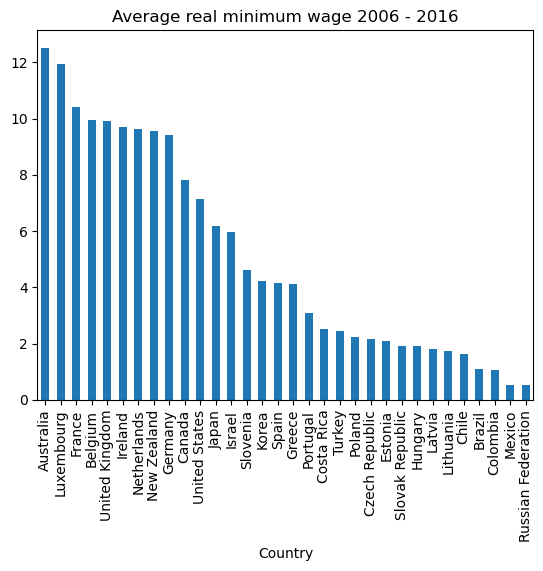

In [112]:
merged.mean().sort_values(ascending=False).plot(kind='bar',
                                                title="Average real minimum wage 2006 - 2016")

# Set country labels
country_labels = merged.mean().sort_values(ascending=False).index.get_level_values('Country').tolist()
plt.xticks(range(0, len(country_labels)), country_labels)
plt.xlabel('Country')

plt.show()

## Exercise to do in class

Compute the average minimum wage across countries over time (i.e., you should get one value for each year, not for each country).

Then plot it as a time series graph.

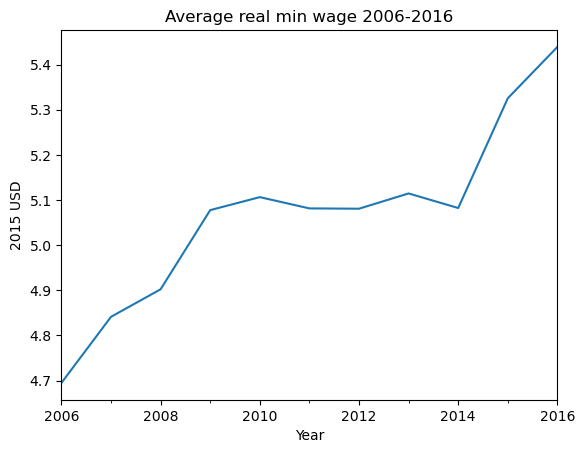

In [114]:
merged.mean(axis=1).head() #axis set to 1 instead of 0 gets year data 
merged.mean(axis=1).plot()

plt.title("Average real min wage 2006-2016")
plt.ylabel("2015 USD")
plt.xlabel("Year")
plt.show()

We can also specify a level of the `MultiIndex` (in the column axis)
to aggregate over

In [117]:
# If we do it at the country level, we basically get back our initial data (we are averaging within a country within one year a variable that is available at the country level at annual frequency, so the one observation we have is then also the average...)
merged.groupby(level='Continent', axis=1).mean().head() #groupby continent gives just four values 

Continent,America,Asia,Australia,Europe
Time,,,,
2006-01-01,2.80,4.29,10.25,4.80
2007-01-01,2.85,4.44,10.73,4.94
2008-01-01,2.99,4.45,10.76,4.99
2009-01-01,3.23,4.53,10.97,5.16
2010-01-01,3.34,4.53,10.95,5.17


We can plot the average minimum wages in each continent as a time series

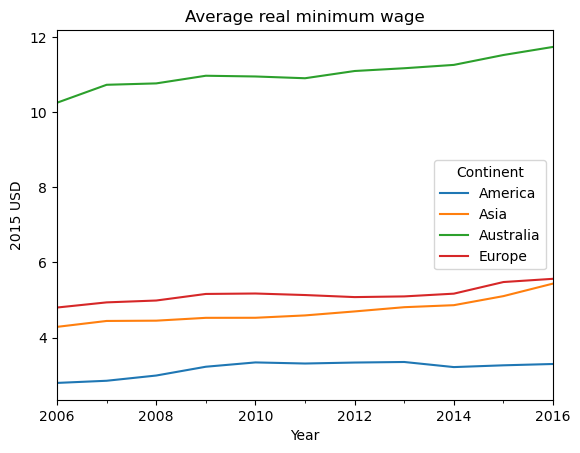

In [122]:
merged.groupby(level='Continent', axis=1).mean().plot()
plt.title('Average real minimum wage')
plt.ylabel('2015 USD')
plt.xlabel('Year')
plt.show()
#time series for just the four countries 


In [124]:
#compare to merge head
merged.head()

Continent  America               ...   Europe                     
Country     Brazil Canada Chile  ... Slovenia Spain United Kingdom
Time                             ...                              
2006-01-01    0.87   6.89  1.42  ...     3.92  3.99           9.81
2007-01-01    0.92   6.96  1.45  ...     3.88  4.10          10.07
2008-01-01    0.96   7.24  1.44  ...     3.96  4.14          10.04
2009-01-01    1.03   7.67  1.52  ...     4.08  4.32          10.15
2010-01-01    1.08   7.94  1.56  ...     4.81  4.30           9.96

[5 rows x 32 columns]

We will drop Australia as a continent for plotting purposes

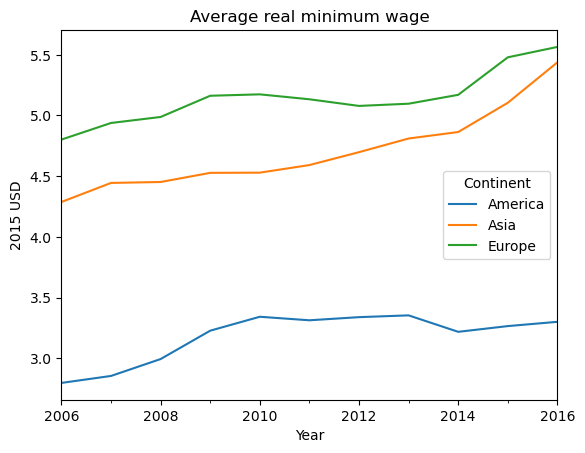

In [127]:
merged = merged.drop('Australia', level='Continent', axis=1)
merged.groupby(level='Continent', axis=1).mean().plot()
plt.title('Average real minimum wage')
plt.ylabel('2015 USD')
plt.xlabel('Year')
plt.show()
#australia was far off so dropped to view other 3 clearer

`.describe()` is useful for quickly retrieving a number of common
summary statistics

In [130]:
merged.describe()

Continent America               ...   Europe                     
Country    Brazil Canada Chile  ... Slovenia Spain United Kingdom
count       11.00  11.00 11.00  ...    11.00 11.00          11.00
mean         1.09   7.82  1.62  ...     4.60  4.16           9.92
std          0.13   0.55  0.16  ...     0.52  0.10           0.20
min          0.87   6.89  1.42  ...     3.88  3.99           9.65
25%          0.99   7.46  1.48  ...     4.02  4.10           9.74
50%          1.09   7.97  1.59  ...     4.94  4.14           9.96
75%          1.21   8.20  1.74  ...     5.00  4.21          10.06
max          1.24   8.48  1.91  ...     5.05  4.32          10.26

[8 rows x 30 columns]

In [132]:
merged.stack().describe() #gives brief descriptive stats, stack makes the stats by continent 

Continent,America,Asia,Europe
count,69.00,44.00,200.00
mean,3.19,4.70,5.15
std,3.02,1.56,3.82
min,0.52,2.22,0.23
25%,1.03,3.37,2.02
50%,1.44,5.48,3.54
75%,6.96,5.95,9.70
max,8.48,6.65,12.39


This is a simplified way to use `groupby`.

Using `groupby` generally follows a ‘split-apply-combine’ process:

- split: data is grouped based on one or more keys  
- apply: a function is called on each group independently  
- combine: the results of the function calls are combined into a new data structure  


The `groupby` method achieves the first step of this process, creating
a new `DataFrameGroupBy` object with data split into groups.

Let’s split `merged` by continent again, this time using the
`groupby` function, and name the resulting object `grouped`

In [135]:
grouped = merged.groupby(level='Continent', axis=1)
grouped